# SENTIMENT ANALYSIS USING NAIVE BAYES ALGORITHM

We will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [44]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [45]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [46]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

In [47]:
df['sentiment'].value_counts()

positive    12474
negative    12225
Name: sentiment, dtype: int64

- I think both the classes of positive and negative reviews are a little imbalanced and also there isn't any noticeable difference between the classes.

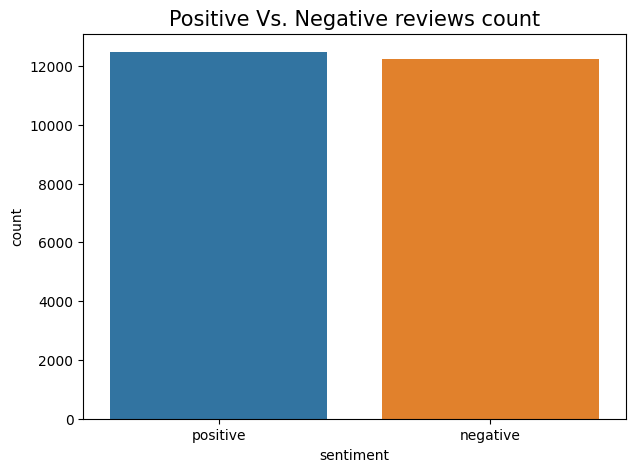

In [48]:
plt.figure(figsize = (7,5))
sns.countplot(data=df,x='sentiment')
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

## Upsampling the minority class:

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

In [49]:
# using resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment']=='positive']
df_minority = df[df['sentiment']=='negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0])

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [50]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled['sentiment']=='negative'].shape

(12474, 2)

In [51]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled['sentiment']=='negative'].shape

(12474, 2)

In [52]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])


In [53]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

positive    10000
negative    10000
Name: sentiment, dtype: int64

In [54]:
y_test.value_counts()

positive    2474
negative    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Pre-process the reviews:

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [55]:
# TASK CELL
import string
import spacy

def clean_review(review):
    url_pattern = r'https?://\S+|www.\.\S+'
    k = re.sub(url_pattern, '', review)
    # punctuation removal
    k = re.sub(r"[^\w\s\t]", "", k) 
    #lowering the alphabets 
    k = k.lower()   
    # tokenizing the words
    k = word_tokenize(k)
    # initializing stop words and applying them
    sw = set(stopwords.words('english'))
    w = [i for i in k if i not in sw]
    # stemming using porter stemmer
    porter_stemmer = PorterStemmer()
    w = [porter_stemmer.stem(i) for i in w]
    # lemmatization 
    # lemma = WordNetLemmatizer()
    # w= [lemma.lemmatize(i) for i in w]
    review_cleaned = ' '.join(w)
    return review_cleaned

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [1]:
# TASK CELL
def find_occurrence(frequency, word, label):
    n =0 
    for i,j in frequency:
        if i[0]==word and i[1]==label:
            n+=j
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [57]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [58]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [59]:
## Choosing a random review and taking a look at it.
X_train.iloc[1]

"I always knew the day was coming. We all knew. There's only so much oil in the ground, and one day we'll run short. But isn't there supposed to be enough coal to use instead? And wind power, or something. Things for future generations to worry about.<br /><br />Then this documentary hit me smack between the eyes. Oil makes the fertilizer that is the reason for the first time in world history practically no one lives on farms. When the inevitable oil shortages hit, a lot of things -- air travel, many drugs, plastics, life in the suburbs -- will become impossible. But the craziest insight from the documentary is this: oil gives us so much energy with so little effort, that without it our lives must change. Even if substitutes and conservation are implemented immediately, at best they'll smooth our landing into a strange post-oil world which (the documentary claims) could be starting NOW.<br /><br />Despite its gloomy message, the documentary is often highly entertaining. It contains fab

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [60]:
custom_review = X_train.iloc[1]

# print cleaned review
print(clean_review(custom_review))

alway knew day come knew there much oil ground one day well run short isnt suppos enough coal use instead wind power someth thing futur gener worri aboutbr br documentari hit smack eye oil make fertil reason first time world histori practic one live farm inevit oil shortag hit lot thing air travel mani drug plastic life suburb becom imposs craziest insight documentari oil give us much energi littl effort without live must chang even substitut conserv implement immedi best theyll smooth land strang postoil world documentari claim could start nowbr br despit gloomi messag documentari often highli entertain contain fabul histor footag sober imag dark urban factori campi funni stuff 1950 remind us move suburb first place also offer hope massiv effort start could eas transit oil make world better placebr br complaint documentari spend time mysteri find stuff big emerg sudden knew 1970 prepar postoil world start prepar altern energi research smaller car failur follow presid jimmi carter init

We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Implementing review counter function:

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [61]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    d1 = dict()
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        key = (word,label)
        # this checks whether the current pair of key already exists in the dictionary or not if not it adds it to the dictionary
        d1[key] = d1.get(key,0)+1
    output_occurrence = d1
    return output_occurrence

In [62]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

In [63]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [64]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('othello', 0): 53,
 ('classic', 0): 1078,
 ('shakespearen', 0): 1,
 ('stori', 0): 5468,
 ('love', 0): 4837,
 ('betray', 0): 101,
 ('lie', 0): 298,
 ('tragedi', 0): 172,
 ('rememb', 0): 911,
 ('studi', 0): 223,
 ('high', 0): 740,
 ('school', 0): 658,
 ('actual', 0): 1681,
 ('found', 0): 1046,
 ('probabl', 0): 1093,
 ('favorit', 0): 886,
 ('shakespear', 0): 174,
 ('due', 0): 408,
 ('fact', 0): 1318,
 ('fascin', 0): 327,
 ('captur', 0): 446,
 ('feel', 0): 2313,
 ('friendship', 0): 220,
 ('racism', 0): 76,
 ('perfectli', 0): 409,
 ('mean', 0): 957,
 ('realli', 0): 4245,
 ('could', 0): 2394,
 ('go', 0): 3277,
 ('mani', 0): 3049,
 ('philosophi', 0): 52,
 ('went', 0): 531,
 ('insan', 0): 167,
 ('jealousi', 0): 34,
 ('blink', 0): 23,
 ('eye', 0): 876,
 ('later', 0): 990,
 ('report', 0): 163,
 ('also', 0): 4174,
 ('watch', 0): 5061,
 ('version', 0): 935,
 ('say', 0): 2631,
 ('absolut', 0): 679,
 ('brilliant', 0): 704,
 ('lawer', 0): 1,
 ('kenneth', 0): 34,
 ('well', 0): 4664,
 ('understood', 

## Training the Naive Bayes Model:

Now we are in the training phase of the Naive Bayes algorithm. In this cell,we will take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [65]:
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set([i[0] for i in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for i in freqs.keys():
        count = freqs[i]
        # if the label is positive (greater than zero)
        if i[1]==0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += count

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += count

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(train_y)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = num_doc - pos_num_docs

    # Calculate logprior
    logprior = np.log(pos_num_docs/neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word,0),0)
        freq_neg = freqs.get((word,1),0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(num_pos+V)
        p_w_neg = (freq_neg+1)/(num_neg+V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [66]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
75470


## Implementing Naive Bayes Predict Function:

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [67]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]

    if total_prob < 0:
        return 1
    else:
        return 0
    # return total_prob

In [68]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


## Implementing Naive Bayes Test function: (10 points)

In this function,we will implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [69]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    accuracy = 0  
    y_hats = []
    for review in test_x:
        pred = naive_bayes_predict(review,logprior,loglikelihood)
        # if the prediction is > 0
        if pred > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats = y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = sum(abs(i-j) for i, j in zip(y_hats, test_y))/len(test_y)

    accuracy = sum(1 for i,j in zip(y_hats,test_y) if i==j)/len(test_y)
    return accuracy

In [70]:
for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


In [71]:
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

# Evaluating the accuracy.

In [72]:
import random
def train_test_splitter(df,seed):
    # shuffling the data using random
    random.seed(seed)
    df_majority = df[df['sentiment']=='positive']
    df_minority = df[df['sentiment']=='negative']

    negative_upsample = resample(df_minority, replace = True, 
                            n_samples = df_majority.shape[0])

    df_upsampled = pd.concat([df_majority, negative_upsample]) 
    # concat two data frames i,e majority class data set and upsampled minority class data set
    df_upsampled = df_upsampled.sample(frac = 1)


    ## Considering 10000 positive and 10000 negative data points
    negative_data_points_train = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[:10000]
    positive_data_points_train = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[:10000]

    ## Considering the remaining data points for test
    negative_data_points_test = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[10000:]
    positive_data_points_test = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[10000:]

    ## Concatenate the training positive and negative reviews
    X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])

    ## Concatenating the training positive and negative outputs
    y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

    ## Concatenating the test positive and negative reviews
    X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
    
    ## Concatenating the test positive and negative outputs
    y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])

    return X_train,X_test,y_train,y_test

In [73]:
X_train,X_test,y_train,y_test = train_test_splitter(df,41)

In [74]:
# mapping the target varibles to 0 and 1 so it can be in numerical form
output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [75]:
# Model paramters with training set.
freqs = review_counter({}, X_train, y_train)
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
75357


In [76]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for train dataset.
train_predicted_labels = [naive_bayes_predict(i, logprior, loglikelihood) for i in X_train]
train_actual_labels = list(y_train)
train_confusion = confusion_matrix(train_actual_labels, train_predicted_labels)

# Confusion matrix for test dataset.
test_predicted_labels = [naive_bayes_predict(i, logprior, loglikelihood) for i in X_test]
test_actual_labels = list(y_test)
test_confusion = confusion_matrix(test_actual_labels, test_predicted_labels)

In [77]:
from sklearn.metrics import classification_report

# Classification report for train dataset.
train_report = classification_report(train_actual_labels, train_predicted_labels)

# Classification report for test dataset.
test_report = classification_report(test_actual_labels, test_predicted_labels)

print("Train Classification Report:\n", train_report)
print("Test Classification Report:\n", test_report)

Train Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93     10000
           1       0.91      0.96      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      2474
           1       0.85      0.89      0.87      2474

    accuracy                           0.87      4948
   macro avg       0.87      0.87      0.87      4948
weighted avg       0.87      0.87      0.87      4948



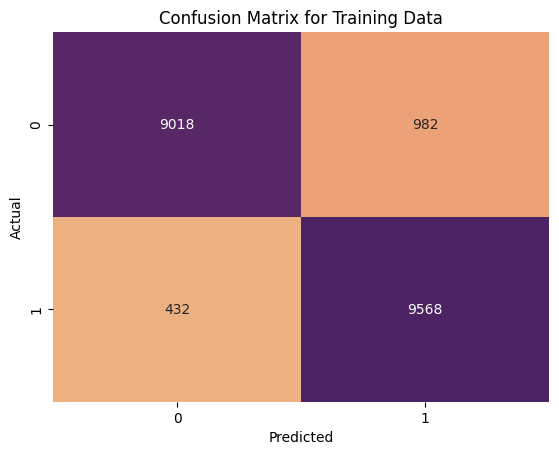

In [78]:
# Plotting Confusion Matrix for Training Data
sns.heatmap(train_confusion, annot=True, cmap="flare", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Training Data")
plt.show()

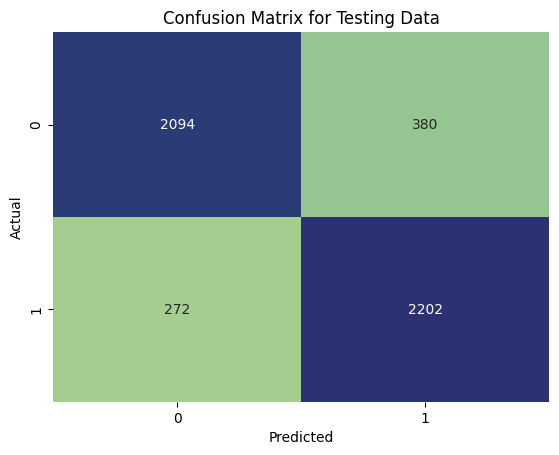

In [79]:
# Plotting Confusion Matrix for Testing Data
sns.heatmap(test_confusion, annot=True, cmap="crest", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [80]:
# creating false positive and negative index list to store the index of fp's and fn's
fp_index = []
fn_index = []
# iterating through y_test to check and store the indexes of fp's and fn's
for i in range(len(y_test)):
    # as we know fp occurs when a model preicts a class 1 as 0 and vice versa for fn 
    # we are implementing them using if and elif, then appending the index
    if y_test.iloc[i]==0 and test_predicted_labels[i]==1:
        fn_index.append(i)
    elif y_test.iloc[i]==1 and test_predicted_labels[i]==0:
        fp_index.append(i)

# now going through the index and getting the reviews 
fp_reviews = [X_test.iloc[i] for i in fp_index]
fn_reviews = [X_test.iloc[i] for i in fn_index]

In [81]:
print("False Postive Cases : \n")
# Now we will be using enumerate function to iterate through fp's with indexing
for index,review in enumerate(fp_reviews[10:14]):
    print(f'Predicted Label : {test_predicted_labels[fp_index[index]]}, Actual Label : {y_test.iloc[fp_index[index]]}')
    print(f'Review : {review}\n')

False Postive Cases : 

Predicted Label : 0, Actual Label : 1
Review : Something of a disappointment. Lee J. Cobb is the anti-union head of Roxton Garments in New York. His partner in the business is killed when an elevator is unleashed and plunges twenty-seven floors to the bottom of the shaft, in the scariest scene in the film.<br /><br />Cobb doesn't know it, or doesn't let himself realize it, but the man behind the killing is Richard Boone, who protects the business from union organizers.<br /><br />Then Cobb's son, Kerwin Mathews, returns from Europe determined to learn the business and join his father in running a clean shop. He's shocked -- shocked! -- to learn that Boone has been clobbering the union members and killing a few who have become irretrievably irritating.<br /><br />Robert Loggia is one of the organizers who is killed by a couple of Boone's goons, led by Wesley Addy. Loggia leaves behind a widow, Gia Scala, with whom Mathews, understandably and decorously, takes up.

**REASON FOR FALSE POSITIVES**
- The Naive Bayes model may have struggled to correctly classify the reviews due to nuanced language and mixed sentiments.
- Improving the model's performance in such situations could involve:
  - Using more advanced machine learning algorithms that capture nuanced sentiment better.
  - Preprocessing the text data more effectively, including handling negations and mixed sentiment expressions.
  - Fine-tuning the model's hyperparameters.

In [82]:
print("False Negative Cases : \n")
# Now we will be using enumerate function to iterate through fn's with indexing
for index,review in enumerate(fn_reviews[1:5]):
    print(f'Predicted Label : {test_predicted_labels[fn_index[index]]}, Actual Label : {y_test.iloc[fn_index[index]]}')
    print(f'False Negative Reviews : {review}\n')

False Negative Cases : 

Predicted Label : 1, Actual Label : 0
False Negative Reviews : Personally, I LOVED TRIS MOVIE! My best friend told me about it so i rented it out a watched it. It's amazing! The music, the acting, the story lines the emotion, everything...... well except for one minor fact. Absolutely no loyalty to the books at all. I saw this movie before Interview with the Vampire and before i even knew the books existed, so i was shocked to find how many people actually hated the movie. I picked up quickly that the book fans weren't at all happy with the unfaithfulness, not wanting to be hypocritical (I hate the Harry Potter movies due to lack of book loyalty)i stayed silent. Eventually i picked up "The Vampire Lestat" and understood immediately why everyone hated it. It is completely different (The movie Queen of the damned is a combination of "The Vampire Lestat" and "The Queen of the Damned"). But i still loved the movie from when i saw it before reading any of the books.

**REASON FOR FALSE NEGATIVES**
- In some situations, positive words or phrases appeared in reviews that otherwise had a negative tone, confusing the model.
- The model also had trouble picking up on irony or sarcasm, which are frequently used in movie reviews.
- Because of its simplicity and reliance on word probabilities, it struggled to handle sophisticated language and delicate nuances.

# Modularizing my calssifier (10 points)
1. Converting my code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [83]:
script_content = '''
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import pickle

warnings.filterwarnings("ignore")
import string
nltk.download('stopwords')

def model_generator():
    df = pd.read_csv("C:/Users/nikhi/Documents/NEU/Fall_23/NLP/Assignments/Assignment 1/movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
    df_majority = df[df['sentiment']=='positive']
    df_minority = df[df['sentiment']=='negative']

    negative_upsample = resample(df_minority, replace = True, 
                            n_samples = df_majority.shape[0])

    df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
    df_upsampled = df_upsampled.sample(frac = 1)

    ## Considering 10000 positive and 10000 negative data points
    negative_data_points_train = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[:10000]
    positive_data_points_train = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[:10000]

    ## Considering the remaining data points for test
    negative_data_points_test = df_upsampled[df_upsampled['sentiment']=='negative'].iloc[10000:]
    positive_data_points_test = df_upsampled[df_upsampled['sentiment']=='positive'].iloc[10000:]

    ## Concatenate the training positive and negative reviews
    X_train = pd.concat([positive_data_points_train['review'], negative_data_points_train['review']])
    ## Concatenating the training positive and negative outputs
    y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

    ## Concatenating the test positive and negative reviews
    X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
    ## Concatenating the test positive and negative outputs
    y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])
    
    def find_occurrence(frequency, word, label):
        n =0 
        for i,j in frequency:
            if i[0]==word and i[1]==label:
                n+=j
        return n
        
    output_map = {'positive': 0, 'negative': 1}
    y_train = y_train.map(output_map)
    y_test = y_test.map(output_map)
    
    def review_counter(output_occurrence, reviews, positive_or_negative):
        d1 = dict()
        for label, review in zip(positive_or_negative, reviews):
            split_review = clean_review(review).split()
            for word in split_review:
                key = (word,label)
                # this checks whether the current pair of key already exists in the dictionary or not if not it adds it to the dictionary
                d1[key] = d1.get(key,0)+1
        output_occurrence = d1
        return output_occurrence
    
    freqs = review_counter({}, X_train, y_train)
    
    def train_naive_bayes(freqs, train_x, train_y):
        loglikelihood = {}
        logprior = 0
        # calculate V, the number of unique words in the vocabulary
        vocab = set([i[0] for i in freqs.keys()])
        V = len(vocab)
        # calculate num_pos and num_neg - the total number of positive and negative words for all documents
        num_pos = num_neg = 0
        for i in freqs.keys():
            count = freqs[i]
            # if the label is positive (greater than zero)
            if i[1]==0:
                # Increment the number of positive words by the count for this (word, label) pair
                num_pos += count
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                num_neg += count
        # Calculate num_doc, the number of documents
        num_doc = len(train_y)
        # Calculate D_pos, the number of positive documents 
        pos_num_docs = sum(train_y)
        # Calculate D_neg, the number of negative documents 
        neg_num_docs = num_doc - pos_num_docs
        # Calculate logprior
        logprior = np.log(pos_num_docs/neg_num_docs)
        # For each word in the vocabulary...
        for word in vocab:
            # get the positive and negative frequency of the word
            freq_pos = freqs.get((word,0),0)
            freq_neg = freqs.get((word,1),0)

            # calculate the probability that each word is positive, and negative
            p_w_pos = (freq_pos+1)/(num_pos+V)
            p_w_neg = (freq_neg+1)/(num_neg+V)

            # calculate the log likelihood of the word
            loglikelihood[word] = np.log(p_w_pos/p_w_neg)
        return logprior, loglikelihood
    logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
    with open('Nikhilfinal_Hw1.pkl', 'wb') as f:
        pickle.dump((freqs, logprior, loglikelihood), f)
def wordTokenizer(val):
    return word_tokenize(val)

def clean_review(review):
    url_pattern = r'https?://\S+|www.\.\S+'
    k = re.sub(url_pattern, '', review)
    # punctuation removal
    k = re.sub(r"[^\w\s\t]", "", k) 
    #lowering the alphabets 
    k = k.lower()   
    # tokenizing the words
    k = word_tokenize(k)
    # initializing stop words and applying them
    sw = set(stopwords.words('english'))
    w = [i for i in k if i not in sw]
    # stemming using porter stemmer
    porter_stemmer = PorterStemmer()
    w = [porter_stemmer.stem(i) for i in w]
    # lemmatization 
    # lemma = WordNetLemmatizer()
    # w= [lemma.lemmatize(i) for i in w]
    review_cleaned = ' '.join(w)
    return review_cleaned
        
def naive_bayes_predict(review, logprior, loglikelihood):
    # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob = total_prob + loglikelihood[word]

    if total_prob < 0:
        return 1
    else:
        return 0

def load_file():
    try:
        with open('Nikhilfinal_Hw1.pkl', 'rb') as f:
            freqs, logprior, loglikelihood = pickle.load(f)
            return freqs, logprior, loglikelihood
    except FileNotFoundError:
        print('Please wait while the model is being generated!')
        model_generator()
        return None
        
if __name__ == "__main__":
    result = load_file()
    
    if result is not None:
        reqs, logprior, loglikelihood = result
    else:
        load_fail = True
        reqs, logprior, loglikelihood = load_file()
        
    while True:
        # Taking user input
        user_input = input("Enter a review for sentiment analysis (or 'XX' to quit): ")

        # Checking if the user wants to quit
        if user_input.strip().upper() == 'XX':
            break

        # Performing sentiment classification
        pred = naive_bayes_predict(user_input, logprior, loglikelihood)

        # Printing results
        # Display sentiment result
        if pred == 0:
            print("Sentiment Analysis Result: Positive review!")
            print(" ")
        else:
            print("Sentiment Analysis Result: Negative review!")
            print(" ")

        #print("Please enter another sentence or 'XX' to quit.")
'''
file_name = "text_classifier_002626733.py"

# Write the script content to the file
with open(file_name, "w") as file:
    file.write(script_content)

print(f"File '{file_name}' has been created.")

File 'text_classifier_002626733.py' has been created.


- There is a problem with maximum likelihood training is lets say we are trying to estimate the likelihood of a word "good" given its class is positive
- But there is no data what so ever that contains the word "good" under positive reviews but it existis in negative reviews
- In this case the probability for such features will be 0 since naive bayes multiplies all the feature likelihood together it will cause the probability of the entire class to be 0
- The solution for this is to use Laplace smoothing also know as additive smoothing is essential in Naive Bayes text classification to address the problem of zero probabilities, sparsity, and overfitting.
- We add a small constant (like 1) to both the numerator and denominator when computing probabilities using Laplace smoothing. This ensures that even if a word isn't in the training set, it will still have a non-zero probability. In the "positive" and "negative" classes, respectively

- In general Naive Bayes calculations for language modelling are done in log space to avoid various problems like underflow and also to handle zero probabilities, increase recision and model interpretability
- By considering features in log space Naive bayes computes the predicted class as a linear function of input features (NB and Logistic)
- Log probabilities prevent numerical underflow issues that can occur when multiplying many small probabilities together in datasets.
- Logs help avoid floating-point precision errors associated with very small or large numbers, ensuring more accurate calculations.
- Log probabilities handle zero probabilities more effectively, even when smoothing techniques like Laplace Smoothing are applied.